In [1]:
from timesteppers import IMEXEuler, IMEXSP, IMEXTrap, ADI
from RDModels import GrayScott
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt

In [2]:
# discretization parameters
L: float = 2.0
Nx: int = 128
discretization: npt.NDArray = np.array([Nx, Nx], dtype=int)
tmin: float = 0.0 
tmax: float = 1000
Nt: int = tmax*4

# Model parameters
F: float = 0.046
k: float = 0.063
Du: float = 2e-5
Dv: float = 1e-5

# Initial condition
x: npt.NDArray = np.linspace(0, L, Nx, endpoint=False)
y: npt.NDArray = np.linspace(0, L, Nx, endpoint=False)
xv, yv = np.meshgrid(x, y)
x1 = 0.50; x2 = 0.55
y1 = 0.50; y2 = 0.6
p1 = np.exp( -25*((xv - x1)**2 + (yv - y1)**2))/2
p2 = np.exp( -25*((xv - x2)**2 + (yv - y2)**2))/2
umatrix = np.ones_like(p1) - p1 - p2
vmatrix = np.zeros_like(p2) + p1 + p2
upart = umatrix.reshape((Nx**2, ))
vpart = vmatrix.reshape((Nx**2, ))
u0: npt.NDArray = np.hstack((upart, vpart))

# Make PDE object
GS: GrayScott = GrayScott(discretization, L, Du, Dv, F, k)

# Make time stepper. Can be either IMEXEuler, IMEXSP or IMEXTrap
imex1: IMEXEuler = IMEXEuler(GS)

# Integrate
res = imex1.integrate(tmin, tmax, Nt, u0)

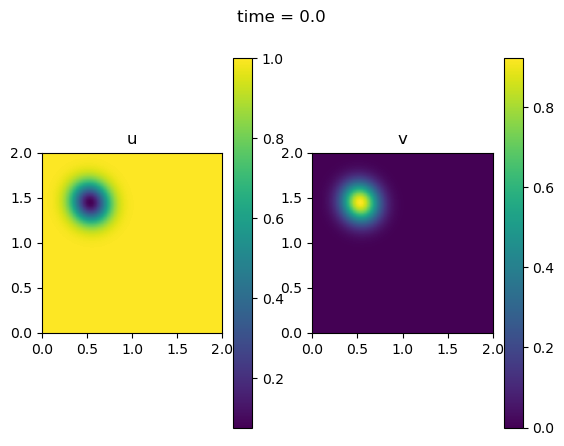

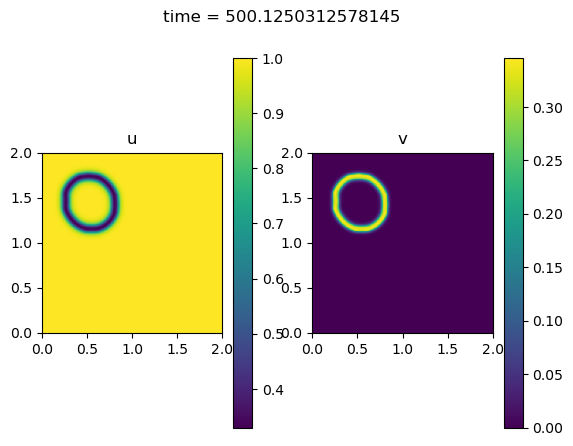

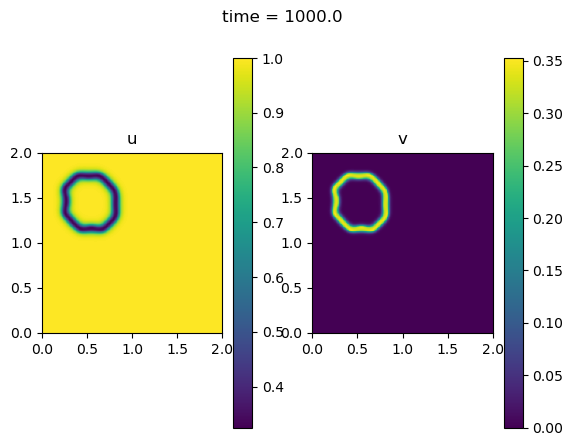

In [3]:
# Plot
imex1.plot(discretization, 0, L)
imex1.plot(discretization, int(Nt/2), L)
imex1.plot(discretization, -1, L)
# imex1.plotAnimation(discretization, L)

In [4]:
Nx = 64
tmax = 200
Nts = np.array([1, 2, 4, 6, 10])*tmax
dts = (tmax - tmin)/(Nts - 1)

# Initial condition
x: npt.NDArray = np.linspace(0, L, Nx, endpoint=False)
y: npt.NDArray = np.linspace(0, L, Nx, endpoint=False)
xv, yv = np.meshgrid(x, y)
x1 = 0.50; x2 = 0.55
y1 = 0.50; y2 = 0.6
p1 = np.exp( -25*((xv - x1)**2 + (yv - y1)**2))/2
p2 = np.exp( -25*((xv - x2)**2 + (yv - y2)**2))/2
umatrix = np.ones_like(p1) - p1 - p2
vmatrix = np.zeros_like(p2) + p1 + p2
upart = umatrix.reshape((Nx**2, ))
vpart = vmatrix.reshape((Nx**2, ))
u0: npt.NDArray = np.hstack((upart, vpart))
x0Matrix: npt.NDArray = np.vstack((umatrix, vmatrix))

# Make PDE object & compute exact solution
discretization: npt.NDArray = np.array([Nx, Nx])
h1: GrayScott = GrayScott(discretization, L, Du, Dv, Fvar=F, k=k)
imex3: IMEXEuler = IMEXEuler(h1)
res = imex3.integrate(tmin, tmax, Nts[-1]*10, u0)
exactSol: npt.NDArray = res[-1, Nx**2:]
exactSolMatrix: npt.NDArray = np.copy(exactSol.reshape((Nx, Nx)))
del imex3

In [10]:
# Compute errors
err: npt.NDArray = np.zeros((Nts.size, 2), dtype=np.float64)

# Make time steppers
imex1: IMEXEuler = IMEXEuler(h1)
adi1: ADI = ADI(h1)

normType: None | str | float = np.inf
for index, Nt in enumerate(Nts):    
    
    # Integrate imex1
    res = imex1.integrate(tmin, tmax, Nt, u0)
    vmax: npt.NDArray = res[-1, Nx**2:]
    err[index, 0] = np.linalg.norm(vmax - exactSol, normType) # type: ignore

    # Integrate imex1
    res = adi1.integrate(tmin, tmax, Nt, x0Matrix)
    vmax: npt.NDArray = res[Nx:, :, -1]
    err[index, 1] = np.linalg.norm(vmax - exactSolMatrix, normType) # type: ignore



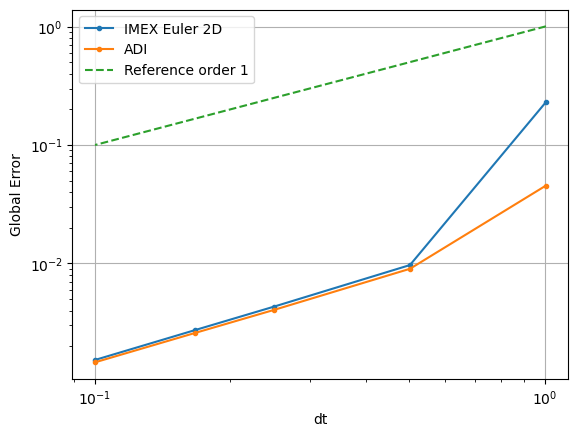

In [11]:
plt.figure(1)
plt.loglog(dts, err[:, 0], '.-', label='IMEX Euler 2D')
plt.loglog(dts, err[:, 1], '.-', label='ADI')
plt.loglog(dts, dts, '--', label='Reference order 1')
plt.xlabel('dt')
plt.ylabel('Global Error')
plt.legend()
plt.grid()
plt.show()